# saved models are named as FreeSound_1D_conv_

In [1]:
import os
import pickle
import pandas as pd
import librosa
import librosa.display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm.notebook as tqdm
from torchsummary import summary
import torch.optim as optim
os.listdir('data/freesound-audio-tagging')

['audio_test',
 'audio_train',
 'free_sound_11025.pkl',
 'free_sound_22050.pkl',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv']

In [2]:
len(os.listdir('data/freesound-audio-tagging/audio_train'))
df = pd.read_csv('data/freesound-audio-tagging/train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [15]:
pickle.dump(Loaded_data, open('data/freesound-audio-tagging/free_sound_11025.pkl', 'wb'))

In [3]:
Loaded_data = {}
if os.path.exists('data/freesound-audio-tagging/free_sound_11025.pkl'):
    Loaded_data = pickle.load(open('data/freesound-audio-tagging/free_sound_11025.pkl', 'rb'))
    
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

def load_audio_file(file_path, input_length=4096):
    
    if file_path not in Loaded_data:
        data = librosa.core.load(file_path, sr=None) 
        data = librosa.core.resample(data[0], data[1], 11025)
        Loaded_data[file_path] = data
    else:
        data = Loaded_data[file_path]
    
    if len(data)>input_length:
        max_offset = len(data)-input_length
        offset = np.random.randint(max_offset)
        data = data[offset:input_length+offset]
        
    else:
        T = np.zeros(input_length, dtype=float)
        T[:len(data)] = data
        data = T
        #max_offset = input_length - len(data)
        ##offset = np.random.randint(max_offset)
        #data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
    data = audio_norm(data)
    return np.array([data])

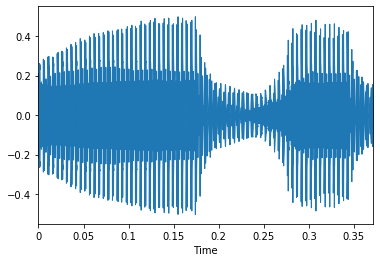

In [5]:
librosa.display.waveplot(load_audio_file('data/freesound-audio-tagging/audio_train/001ca53d.wav')[0],
                         sr=11025, 
                         max_points=50000.0, 
                         x_axis='time', 
                         offset=0.0)

# Data Loading

In [6]:
labels = sorted(set(df.label))
label_to_indice = {l:i for i,l in enumerate(labels)}
indice_to_label = {i:l for i,l in enumerate(labels)}

In [7]:
class FreeSoundDataset(torch.utils.data.Dataset):
    def __init__(self, df_path, data_path, train=True, split=0.8):
        
        self.df = pd.read_csv(df_path)
        
        self.df = self.df[:int(len(self.df)*split)] if train else self.df[int(len(self.df)*split):]
        
        self.data_path = data_path
        self.input_length = 4096
        self.batch_size = 32
        
        self.labels = sorted(set(self.df.label))
        self.label_to_indice = {l:i for i,l in enumerate(self.labels)}
        self.indice_to_label = {i:l for i,l in enumerate(self.labels)}
    
    def __len__(self):
        return len(self.df)-2
    
    def __getitem__(self, idx):
        file_path = self.data_path + list(df[idx: idx+1].fname)[0]
        label_indice = label_to_indice[list(df[idx: idx+1].label)[0]]
        return load_audio_file(file_path), label_indice
        

In [8]:
sr = 11025
def bandpass_filter(signal, low, high, order = 5):
    sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
    y = sosfilt(sos, signal)
    return y
    
def make_signal(raw_signal, nyq = sr/2):
    return_signal = np.zeros((8, self.input_length))
    return_signal[0] = raw_signal

    cut_offs = [i/nyq for i in [1, 256, 512, 1024, 2048, 4096, 8192, 11024]]
    for i in range(1, len(cut_offs), 1):
        return_signal[i] = bandpass_filter(raw_signal, cut_offs[i-1], cut_offs[i])
    return return_signal
        
    
def shuffletwo(x, y):
    rng_state = np.random.get_state()
    np.random.shuffle(x)
    np.random.set_state(rng_state)
    np.random.shuffle(y)

In [9]:
mini_batch_size = 96
FreeSoundData = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                 'data/freesound-audio-tagging/audio_train/')
FreeSoundDataTest = FreeSoundDataset('data/freesound-audio-tagging/train.csv',
                                     'data/freesound-audio-tagging/audio_train/',
                                     train=False)
FreeSoundDataLoader = DataLoader(FreeSoundData, batch_size=mini_batch_size, shuffle=True)
FreeSoundDataTestLoader = DataLoader(FreeSoundDataTest, batch_size=mini_batch_size, shuffle=True)

In [10]:
FreeSoundData[0][0].shape

(1, 4096)

# Model

In [11]:
class FreeSound_Sense(torch.nn.Module):
    
    def __init__(self):
        super(FreeSound_Sense, self).__init__()
        self.conv1d_1_16_9 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_16_9 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=9, padding=True)
        self.conv1d_16_32_3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_32_3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=True)
        self.conv1d_32_96_3 = nn.Conv1d(in_channels=32, out_channels=96, kernel_size=3, padding=True)
        self.conv1d_96_96_3 = nn.Conv1d(in_channels=96, out_channels=96, kernel_size=3, padding=True)
        
        self.maxpool_16 = nn.MaxPool1d(16)
        self.maxpool_4 = nn.MaxPool1d(4)
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        
        self.fc_96_64 = nn.Linear(in_features=96, out_features=64)
        self.fc_64_512 = nn.Linear(in_features=64, out_features=512)
        self.fc_512_42 = nn.Linear(in_features=512, out_features=42)
        
        
    def forward(self, x):
        
        # First Block
        x = self.conv1d_1_16_9(x)
        x = self.relu(x)
        x = self.conv1d_16_16_9(x)
        x = self.relu(x)
        x = self.maxpool_16(x)
        x = self.dropout(x)
        
        # Second Block
        x = self.conv1d_16_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Third Block
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.conv1d_32_32_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = self.dropout(x)
        
        # Fourth Block
        x = self.conv1d_32_96_3(x)
        x = self.relu(x)
        x = self.conv1d_96_96_3(x)
        x = self.relu(x)
        x = self.maxpool_4(x)
        x = torch.mean(x, 2)
 
        # Final Layers
        x = torch.flatten(x, start_dim=1)
        x = self.fc_96_64(x)
        x = self.relu(x)
        x = self.fc_64_512(x)
        x = self.relu(x)
        x = self.fc_512_42(x)
        x = self.softmax(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Model = FreeSound_Sense()
Model.float()
Model.to(device)
summary(Model, (1, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 16, 4090]             160
              ReLU-2             [-1, 16, 4090]               0
            Conv1d-3             [-1, 16, 4084]           2,320
              ReLU-4             [-1, 16, 4084]               0
         MaxPool1d-5              [-1, 16, 255]               0
           Dropout-6              [-1, 16, 255]               0
            Conv1d-7              [-1, 32, 255]           1,568
              ReLU-8              [-1, 32, 255]               0
            Conv1d-9              [-1, 32, 255]           3,104
             ReLU-10              [-1, 32, 255]               0
        MaxPool1d-11               [-1, 32, 63]               0
          Dropout-12               [-1, 32, 63]               0
           Conv1d-13               [-1, 32, 63]           3,104
             ReLU-14               [-1,

In [16]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(Model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(Model.parameters(), lr=0.00025, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
epoch_progress_bar = tqdm.tqdm(range(0, 333))
for epoch in epoch_progress_bar:
    avg_epoch_loss = 0
    data_progress_bar = tqdm.tqdm(FreeSoundDataLoader)
    positives=0
    for data, targets in data_progress_bar:
        data = data.float().to(device)
        targets = targets.long().to(device)
        

        optimizer.zero_grad()
        outputs = Model(data)
        

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()
        avg_epoch_loss+=loss_val
        data_progress_bar.set_description(desc="Loss: "+str(loss_val))
        
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        targets = targets.cpu().numpy()
        positives += np.sum(targets==outputs)
    
    print('Epoch Loss: ', str(avg_epoch_loss/len(FreeSoundDataLoader)))
    print('Train Acc ', str(positives*100/(len(FreeSoundDataLoader)*mini_batch_size)))
    
    # Validation
    data_test_progress_bar = tqdm.tqdm(FreeSoundDataTestLoader)
    positives=0
    for data, targets in data_test_progress_bar:
        data = data.float().to(device)
        targets = targets.numpy()
        outputs = Model(data)
        outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        positives += np.sum(targets==outputs)
        
    print('Valid Acc ', str(positives*100/(len(FreeSoundDataTestLoader)*mini_batch_size)))


Epoch Loss:  3.577364444732666
Train Acc  19.963080168776372



Valid Acc  20.364583333333332



Epoch Loss:  3.5700215961359723
Train Acc  20.7542194092827



Valid Acc  19.166666666666668



Epoch Loss:  3.563453607921359
Train Acc  21.29483122362869



Valid Acc  20.0



Epoch Loss:  3.5693104357659062
Train Acc  20.661919831223628



Valid Acc  19.583333333333332



Epoch Loss:  3.562854649145392
Train Acc  21.42668776371308



Valid Acc  21.458333333333332



Epoch Loss:  3.563799664944033
Train Acc  21.439873417721518



Valid Acc  19.895833333333332



Epoch Loss:  3.560321569442749
Train Acc  21.822257383966246



Valid Acc  21.09375



Epoch Loss:  3.562255808069736
Train Acc  21.453059071729957



Valid Acc  20.833333333333332



Epoch Loss:  3.5594400665428063
Train Acc  21.848628691983123



Valid Acc  21.25



Epoch Loss:  3.5658335444293443
Train Acc  21.110232067510548



Valid Acc  21.5625



Epoch Loss:  3.5670872368390047
Train Acc  21.044303797468356



Valid Acc  20.677083333333332



Epoch Loss:  3.556687880165969
Train Acc  22.1123417721519



Valid Acc  20.9375



Epoch Loss:  3.5622357205499577
Train Acc  21.479430379746834



Valid Acc  19.166666666666668



Epoch Loss:  3.562787258172337
Train Acc  21.321202531645568



Valid Acc  21.875



Epoch Loss:  3.560700054410138
Train Acc  21.65084388185654



Valid Acc  22.1875



Epoch Loss:  3.5588034104697313
Train Acc  21.75632911392405



Valid Acc  21.979166666666668



Epoch Loss:  3.559767861909504
Train Acc  21.75632911392405



Valid Acc  21.09375



Epoch Loss:  3.5625885740111145
Train Acc  21.453059071729957



Valid Acc  21.458333333333332



Epoch Loss:  3.563738131824928
Train Acc  21.321202531645568



Valid Acc  21.458333333333332



Epoch Loss:  3.556479713584803
Train Acc  22.19145569620253



Valid Acc  22.1875


In [14]:
torch.save(Model.state_dict(), "model_weights/FreeSound_1D_conv_small_164_epoch.stDict")

In [174]:
i=0
for data in FreeSoundDataLoader:
    if i==4:
        O = Model(data[0].float().to(device))
        A = data[1]
        #print(data[1])
        break
    i+=1
O = O.detach().cpu().numpy()
K = np.argmax(O, axis=1)==A.numpy()
print(np.sum(K)/len(K), np.sum(K))
list(zip(A, K))

0.3125 10


[(tensor(0), False),
 (tensor(3), True),
 (tensor(12), False),
 (tensor(25), False),
 (tensor(15), True),
 (tensor(20), False),
 (tensor(4), False),
 (tensor(12), False),
 (tensor(34), False),
 (tensor(13), False),
 (tensor(24), False),
 (tensor(26), True),
 (tensor(7), False),
 (tensor(22), False),
 (tensor(40), True),
 (tensor(20), True),
 (tensor(17), True),
 (tensor(32), True),
 (tensor(7), False),
 (tensor(24), False),
 (tensor(29), False),
 (tensor(10), False),
 (tensor(38), True),
 (tensor(34), False),
 (tensor(30), True),
 (tensor(17), False),
 (tensor(26), True),
 (tensor(18), False),
 (tensor(12), False),
 (tensor(17), False),
 (tensor(1), False),
 (tensor(39), False)]